# Packages and Data Import

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import  StratifiedKFold, RandomizedSearchCV
from sklearn.manifold import TSNE
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, LabelEncoder

import umap
from scipy import stats
from pathlib import Path
import os
import random
os.environ['TF_DETERMINISTIC_OPS'] = '1'

import tensorflow as tf

Pulling data from downloaded files. Test and train data has already been divided from source. Goal is to reach 96% accuracy (where a study was conducted that SVM yielded ~96%.)

In [2]:
main_dir = Path().cwd() / 'UCI HAR Dataset'
train_dir = main_dir / 'train'
test_dir = main_dir / 'test'

labels_map = {
    1: 'WALKING',
    2: 'WALKING_UPSTAIRS',
    3: 'WALKING_DOWNSTAIRS',
    4: 'SITING',
    5: 'STANDING',
    6: 'LAYING'
}

X_train = pd.read_csv(train_dir / 'X_train.txt',  sep=' ', skipinitialspace=True, header=None)
X_test = pd.read_csv(test_dir / 'X_test.txt', sep=' ', skipinitialspace=True, header=None)
y_train = pd.read_csv(train_dir / 'y_train.txt', sep=' ', skipinitialspace=True, header=None).replace(labels_map)
y_test = pd.read_csv(test_dir / 'y_test.txt', sep=' ', skipinitialspace=True, header=None).replace(labels_map)

le = LabelEncoder()
y_train_le = le.fit_transform(y_train.to_numpy().ravel())
y_test_le = le.transform(y_test.to_numpy().ravel())

Checking of the shapes of the data.

In [3]:
names = ['X_train', 'X_test', 'y_train', 'y_test']
dfs = [X_train, X_test, y_train_le, y_test_le]

for name, df in zip(names, dfs):
    print(f'Shape of {name} is {df.shape}')

Shape of X_train is (7352, 561)
Shape of X_test is (2947, 561)
Shape of y_train is (7352,)
Shape of y_test is (2947,)


Randomly selecting 16 features and visualizing the distribution.

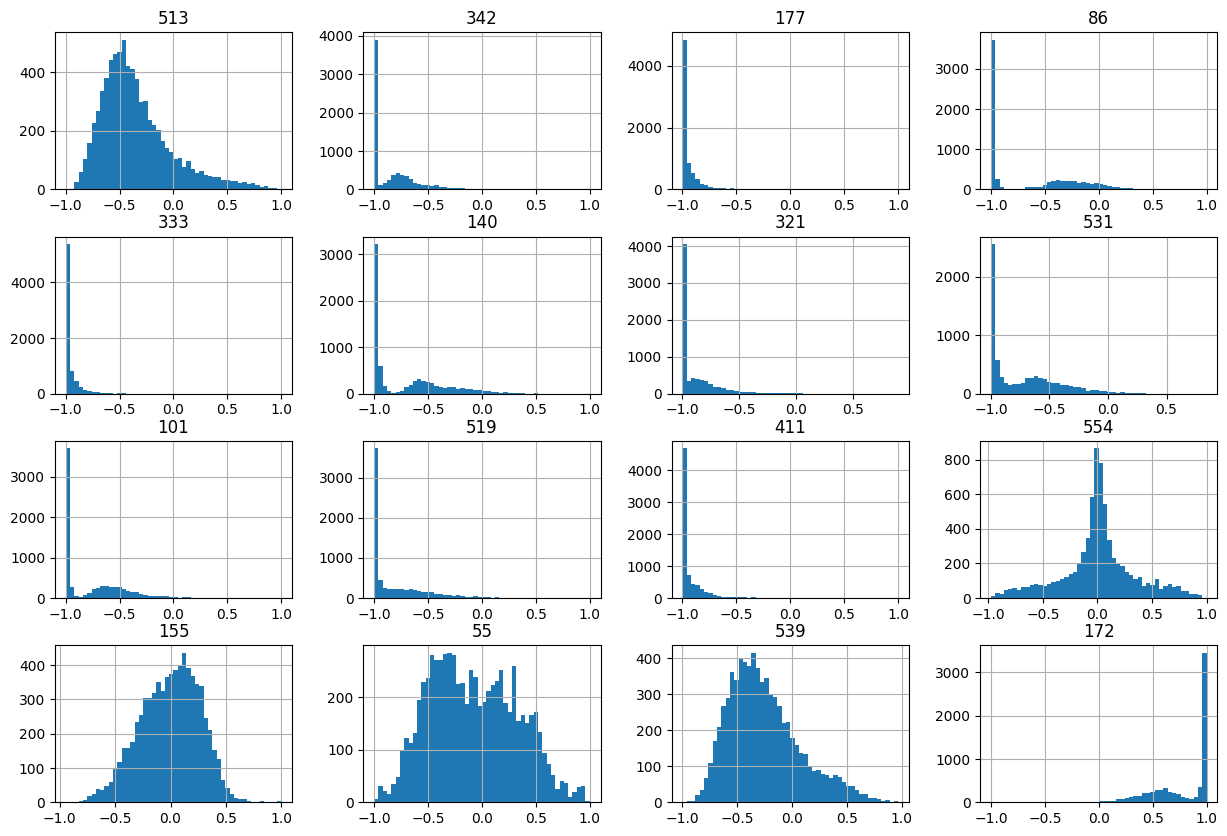

In [4]:
sampled_columns = X_train.sample(n=16, axis=1, random_state=42)
sampled_columns.hist(bins=50, figsize=(15, 10));

Visualization of the distribution of labels.

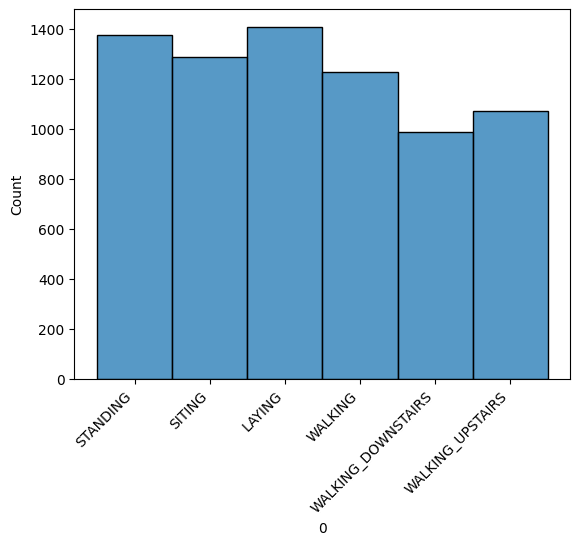

In [5]:
sns.histplot(y_train, x=0)
plt.xticks(rotation=45, ha='right');

## 2D Visualization using TSNE

Visualization of the dataset reduced to 2-Dimensions using t-SNE.

In [6]:
X_train_2d = TSNE(n_components=2).set_output(transform='pandas').fit_transform(X_train)

<Axes: xlabel='tsne0', ylabel='tsne1'>

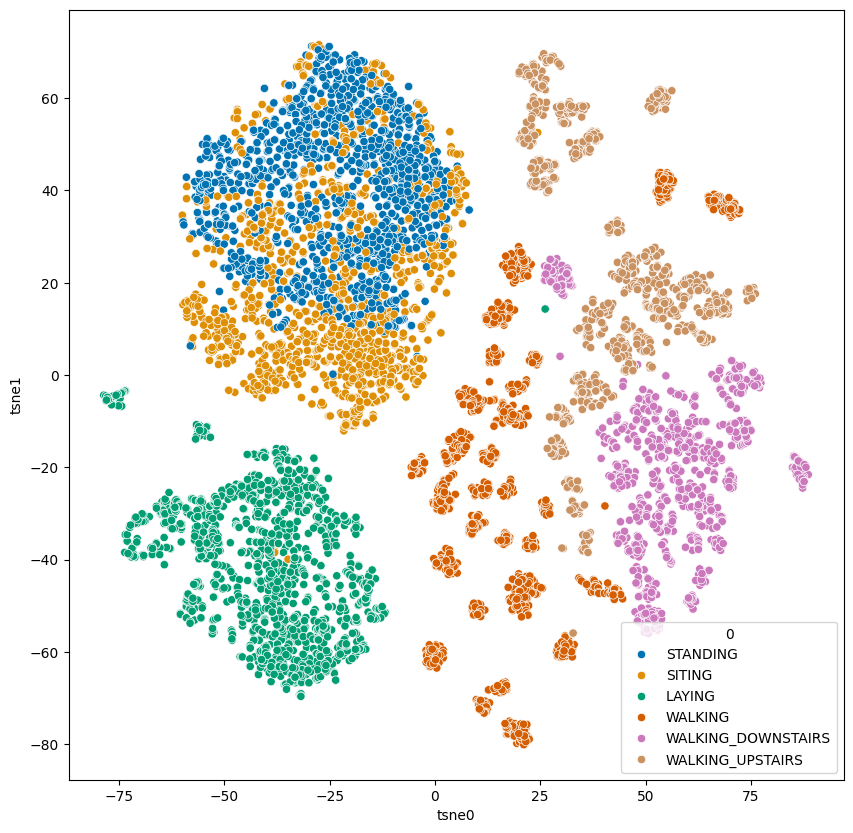

In [7]:
plt.figure(figsize=(10, 10))
sns.scatterplot(pd.concat([X_train_2d, y_train], axis=1), x='tsne0', y='tsne1', hue=0, palette='colorblind')

## 2D Visualization using UMAP

Visualization of the dataset reduced to 2-Dimensions using UMAP.

In [8]:
X_train_2d_2 = umap.UMAP(n_components=2).fit_transform(X_train)
X_train_2d_2 = pd.DataFrame(X_train_2d_2, columns=['c1', 'c2'])
X_train_2d_2

,c1,c2
0,-8.909481,5.631848
1,-6.407605,4.282226
2,-7.124794,4.587234
3,-6.367911,4.107920
4,-7.453119,4.184821
...,...,...
7347,7.540905,16.893219
7348,7.596031,16.901314
7349,7.660312,16.982407
7350,7.625049,16.956572


<Axes: xlabel='c1', ylabel='c2'>

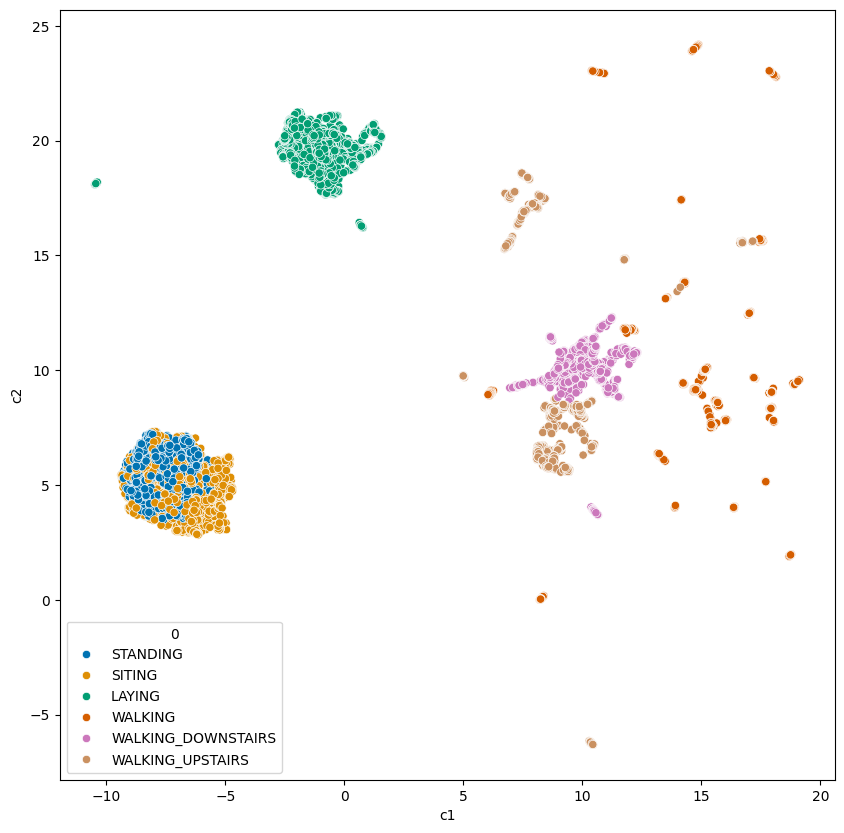

In [9]:
plt.figure(figsize=(10, 10))
sns.scatterplot(pd.concat([X_train_2d_2, y_train], axis=1), x='c1', y='c2', hue=0, palette='colorblind')

# Scikit-learn's Neural Network

## Base Model

Creating a base DNN model (no hypertuning performed) for comparison.

In [10]:
model_base = MLPClassifier(random_state=42)

In [11]:
model_base.fit(X_train, y_train_le)

MLPClassifier(random_state=42)

In [12]:
model_base.score(X_test, y_test_le)

0.9545300305395318

In [13]:
print(classification_report(y_test_le, model_base.predict(X_test), target_names=le.classes_))

                    precision    recall  f1-score   support

            LAYING       1.00      0.98      0.99       537
            SITING       0.95      0.92      0.93       491
          STANDING       0.91      0.96      0.93       532
           WALKING       0.94      0.99      0.96       496
WALKING_DOWNSTAIRS       1.00      0.93      0.96       420
  WALKING_UPSTAIRS       0.94      0.94      0.94       471

          accuracy                           0.95      2947
         macro avg       0.96      0.95      0.95      2947
      weighted avg       0.96      0.95      0.95      2947



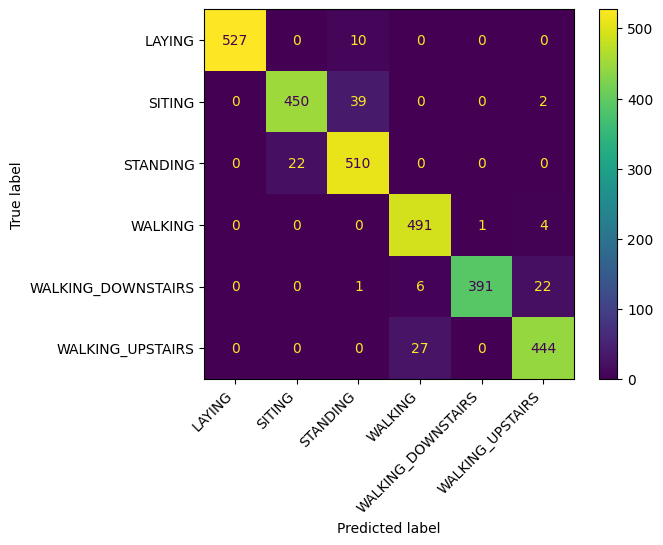

In [14]:
ConfusionMatrixDisplay.from_estimator(model_base, X_test, y_test_le, display_labels=le.classes_)
plt.xticks(rotation=45, ha='right');

## Hypertuned Model

Creating a hypertuned DNN (3 hidden layers with random units per layer)

In [15]:
model_ht = MLPClassifier(random_state=42)

param_distributions = {
    'hidden_layer_sizes': 
    (
        [(i, j, k) for i in range(20, 201, 20) for j in range(20, i+1, 20) for k in range(20, j+1, 20)] + 
        [(i, j) for i in range(20, 201, 20) for j in range(20, i+1, 20)] + 
        [(i) for i in range(20, 201, 20)]
    ),
    'activation': ['logistic', 'tanh', 'relu'],
    'solver': ['sgd', 'adam', 'lbfgs'],
    'alpha': stats.loguniform(0.001, 1),
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'learning_rate_init': stats.loguniform(0.001, 0.1),
    'power_t': stats.loguniform(0.1, 0.99),
    'momentum': stats.uniform(0.1, 0.8),
    'beta_1': stats.uniform(0.1, 0.8), 
    'beta_2': stats.uniform(0.1, 0.899),
    'epsilon': stats.loguniform(1e-8, 0.9),
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

random_search_model_ht = RandomizedSearchCV(
    estimator=model_ht,
    param_distributions=param_distributions,
    n_iter=100,
    scoring='accuracy',
    verbose=3,
    cv=cv,
    return_train_score=True,
    n_jobs=-1,
    random_state=42
)

random_search_model_ht.fit(X_train, y_train_le)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


c:\Users\Deomary\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=MLPClassifier(random_state=42), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'activation': ['logistic', 'tanh',
                                                       'relu'],
                                        'alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001AA8CDBBA70>,
                                        'beta_1': <scipy.stats._distn_infrastructure.rv_continuous...
                                        'learning_rate_init': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001AA8CDB9010>,
                                        'momentum': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001AA86DF83E0>,
                                        'power_t': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001AA8CDBA2D0>,
                                        'solver': ['sgd', 'adam', 'lbfgs']},
                   random_state=42, return_train_score=True, scoring='accuracy',
                   verbose=3)

In [16]:
print(f'best score: {random_search_model_ht.best_score_}\n')
print(f'best params: {random_search_model_ht.best_params_}\n')
print(classification_report(y_test_le, random_search_model_ht.best_estimator_.predict(X_test)))

best score: 0.9850380103081623

best params: {'activation': 'logistic', 'alpha': np.float64(0.1131656555697091), 'beta_1': np.float64(0.17029448899412547), 'beta_2': np.float64(0.22480347132437634), 'epsilon': np.float64(1.0509042571947813e-08), 'hidden_layer_sizes': (180, 180), 'learning_rate': 'adaptive', 'learning_rate_init': np.float64(0.008837560544848171), 'momentum': np.float64(0.5848815048446709), 'power_t': np.float64(0.6177639071901171), 'solver': 'lbfgs'}

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       537
           1       0.97      0.91      0.94       491
           2       0.92      0.97      0.95       532
           3       0.94      0.99      0.96       496
           4       0.98      0.96      0.97       420
           5       0.96      0.92      0.94       471

    accuracy                           0.96      2947
   macro avg       0.96      0.96      0.96      2947
weighted avg       0.96      0.96      0

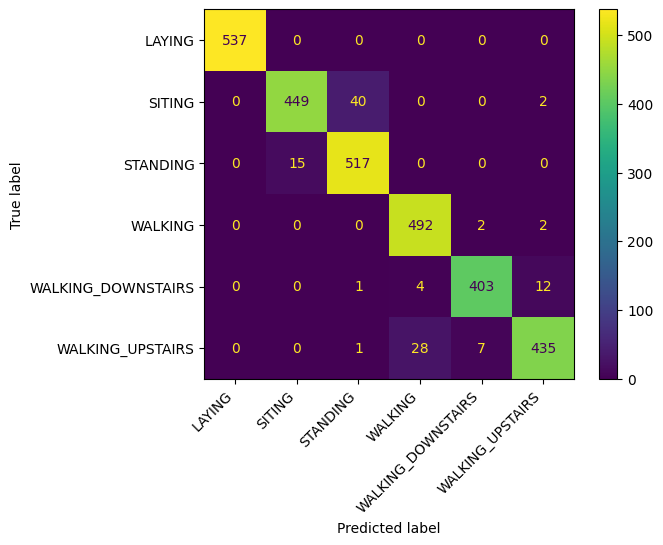

In [17]:
ConfusionMatrixDisplay.from_estimator(random_search_model_ht.best_estimator_, X_test, y_test_le, display_labels=le.classes_)
plt.xticks(rotation=45, ha='right');

# Tensorflow

Creating a DNN using Tensorflow and seeing if this kind of Neural Network has significant effects.

In [18]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

model_tf = tf.keras.models.Sequential([
    tf.keras.Input(shape=(561, )),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(40, activation='relu'),
    tf.keras.layers.Dense(40, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10 ** (epoch / 20)
)

optimizer = tf.keras.optimizers.SGD(momentum=0.9)
model_tf.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=optimizer)
history = model_tf.fit(X_train, y_train_le, epochs=200, callbacks=[lr_schedule])

Epoch 1/200
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 736us/step - loss: 1.7984 - learning_rate: 1.0000e-08
Epoch 2/200
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step - loss: 1.7983 - learning_rate: 1.1220e-08
Epoch 3/200
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step - loss: 1.7983 - learning_rate: 1.2589e-08
Epoch 4/200
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step - loss: 1.7982 - learning_rate: 1.4125e-08
Epoch 5/200
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - loss: 1.7981 - learning_rate: 1.5849e-08
Epoch 6/200
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - loss: 1.7980 - learning_rate: 1.7783e-08
Epoch 7/200
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - loss: 1.7979 - learning_rate: 1.9953e-08
Epoch 8/200
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step - loss: 1.7977 - learning_rate: 2.2387e-08
Epoch 9/200
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - loss: 1.7975 - learning_rate: 2.5119e-08
Epoch 10/200
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step - loss: 1.7973 - learning_rate: 2.8184e-08
Epoch 11/200
230/23

(np.float64(1e-08), np.float64(0.01), np.float64(0.0), np.float64(2.0))

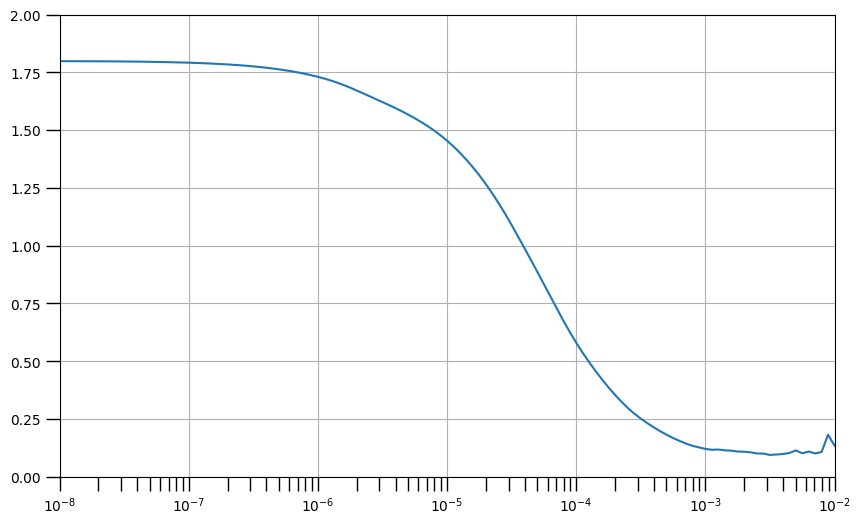

In [19]:
lrs = 1e-8 * (10 ** (np.arange(200) / 20))
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.semilogx(lrs, history.history['loss'])
plt.tick_params('both', length=10, width=1, which='both')
plt.axis([1e-8, 1e-2, 0, 2])

From here, the learning_rate with lowest loss (and still part of the smooth curvature) is about 10^-3. Hence this will be selected as the learning_rate for training.

In [20]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

model_tf = tf.keras.models.Sequential([
    tf.keras.Input(shape=(561, )),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(40, activation='relu'),
    tf.keras.layers.Dense(40, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

model_tf.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9), 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
    metrics=['accuracy']
)

history = model_tf.fit(X_train, y_train_le, epochs=500, batch_size=32)

Epoch 1/500
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 852us/step - accuracy: 0.4297 - loss: 1.3167
Epoch 2/500
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step - accuracy: 0.8161 - loss: 0.5170
Epoch 3/500
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step - accuracy: 0.8736 - loss: 0.3319
Epoch 4/500
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - accuracy: 0.9043 - loss: 0.2555
Epoch 5/500
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - accuracy: 0.9184 - loss: 0.2125
Epoch 6/500
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step - accuracy: 0.9301 - loss: 0.1818
Epoch 7/500
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step - accuracy: 0.9429 - loss: 0.1574
Epoch 8/500
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - accuracy: 0.9487 - loss: 0.1393
Epoch 9/500
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - accuracy: 0.9544 - loss: 0.1262
Epoch 10/500
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - accuracy: 0.9572 - loss: 0.1156
Epoch 11/500
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step - accuracy: 0.9607 - loss: 0.1068
Epoch 12/500
230/23

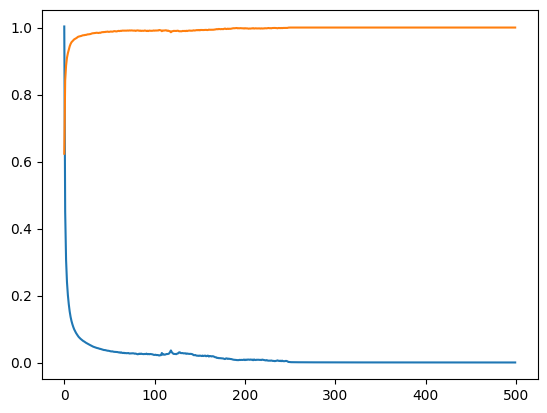

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])

In [22]:
model_tf.evaluate(X_test, y_test_le)

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - accuracy: 0.9490 - loss: 0.3139


[0.2629862129688263, 0.9558873176574707]

In [23]:
print(classification_report(y_test_le, np.argmax(model_tf.predict(X_test), axis=1), target_names=le.classes_))

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
            SITING       0.98      0.90      0.94       491
          STANDING       0.91      0.98      0.94       532
           WALKING       0.94      0.98      0.96       496
WALKING_DOWNSTAIRS       0.98      0.94      0.96       420
  WALKING_UPSTAIRS       0.94      0.93      0.94       471

          accuracy                           0.96      2947
         macro avg       0.96      0.95      0.96      2947
      weighted avg       0.96      0.96      0.96      2947



93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step


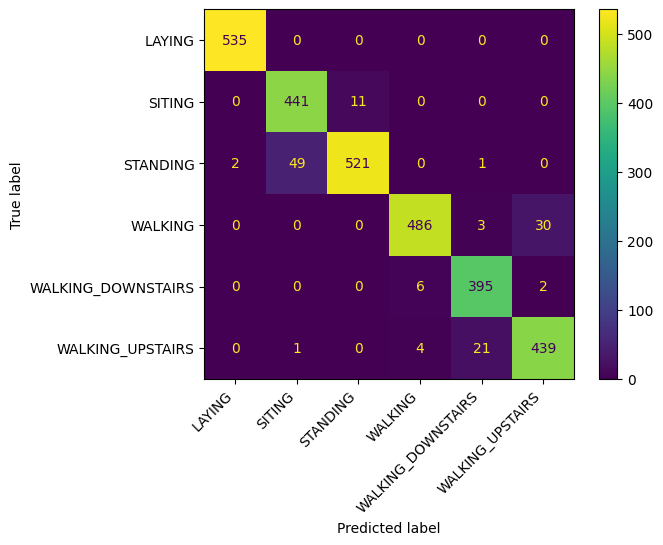

In [24]:
ConfusionMatrixDisplay.from_predictions(np.argmax(model_tf.predict(X_test), axis=1), y_test_le, display_labels=le.classes_)
plt.xticks(rotation=45, ha='right');

# Dimensionality Reduction

Reducing the 500+ features before training it to a Neural Network. Here, the number of features will be based on PCA whose explained variance is 95%. Then an autoencoder will be used to reduce the dimensions to chosen number of features.

In [25]:
pca = PCA(n_components=.95).fit(X_train)
pca.n_components_

np.int64(67)

In [26]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

encoding_dim = pca.n_components_

autoencoder = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(561, )),
    tf.keras.layers.Dense(280, activation='relu'),
    tf.keras.layers.Dense(140, activation='relu'),
    tf.keras.layers.Dense(encoding_dim, activation='relu'),
    
    tf.keras.layers.Dense(140, activation='relu'),
    tf.keras.layers.Dense(280, activation='relu'),
    tf.keras.layers.Dense(561, activation='sigmoid')
])

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder_history = autoencoder.fit(X_train, X_train, epochs=50, batch_size=32)

Epoch 1/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6142
Epoch 2/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5116
Epoch 3/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5103
Epoch 4/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5096
Epoch 5/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5088
Epoch 6/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5076
Epoch 7/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5066
Epoch 8/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5059
Epoch 9/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5052
Epoch 10/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5048
Epoch 11/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5044
Epoch 12/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5042
Epoch 13/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5040
Epoch 14/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5039
Epoch 15/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step


<Axes: xlabel='col1', ylabel='col2'>

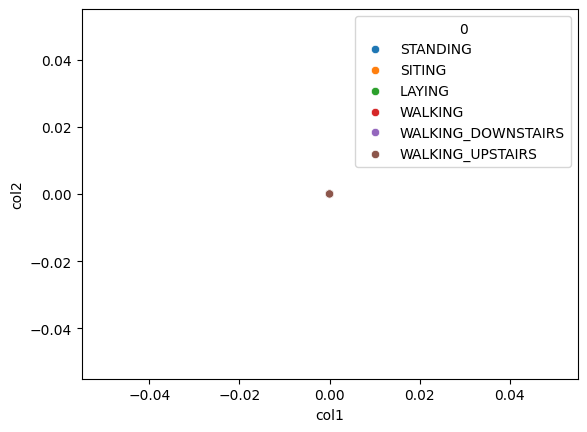

In [27]:
encoder = tf.keras.models.Sequential(autoencoder.layers[:3])
X_train_reduced = encoder.predict(X_train)
X_test_reduced = encoder.predict(X_test)

autoencoded_data = pd.concat([pd.DataFrame(X_train_reduced[:, :2], columns=['col1', 'col2']), y_train], axis=1)

sns.scatterplot(autoencoded_data, x='col1', y='col2', hue=0)

# Scikit-learn's Neural Network on Reduced Dimension

In [28]:
model_ht_reduced = MLPClassifier(random_state=42)

param_distributions = {
    'hidden_layer_sizes':
    (
        [(i, j, k) for i in range(20, 201, 20) for j in range(20, i+1, 20) for k in range(20, j+1, 20)] + 
        [(i, j) for i in range(20, 201, 20) for j in range(20, i+1, 20)] + 
        [(i) for i in range(20, 201, 20)]
    ),
    'activation': ['logistic', 'tanh', 'relu'],
    'solver': ['sgd', 'adam', 'lbfgs'],
    'alpha': stats.loguniform(0.001, 1),
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'learning_rate_init': stats.loguniform(0.001, 0.01),
    'power_t': stats.loguniform(0.1, 0.99),
    'momentum': stats.uniform(0.1, 0.8),
    'beta_1': stats.uniform(0.1, 0.8), 
    'beta_2': stats.uniform(0.1, 0.899),
    'epsilon': stats.loguniform(1e-8, 0.9),
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

random_search_model_ht_reduced = RandomizedSearchCV(
    estimator=model_ht_reduced,
    param_distributions=param_distributions,
    n_iter=50,
    scoring='accuracy',
    verbose=3,
    cv=cv,
    return_train_score=True,
    n_jobs=-1,
    random_state=42
)

random_search_model_ht_reduced.fit(X_train_reduced, y_train_le)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=MLPClassifier(random_state=42), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'activation': ['logistic', 'tanh',
                                                       'relu'],
                                        'alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001AA8C86E1E0>,
                                        'beta_1': <scipy.stats._distn_infrastructure.rv_continuous_...
                                        'learning_rate_init': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001AA84C43A70>,
                                        'momentum': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001AA88069340>,
                                        'power_t': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001AA84C40FB0>,
                                        'solver': ['sgd', 'adam', 'lbfgs']},
                   random_state=42, return_train_score=True, scoring='accuracy',
                   verbose=3)

In [29]:
print(f'best score: {random_search_model_ht_reduced.best_score_}\n')
print(f'best params: {random_search_model_ht_reduced.best_params_}\n')
print(classification_report(y_test_le, random_search_model_ht_reduced.best_estimator_.predict(X_test_reduced), target_names=le.classes_))

best score: 0.9638194045468045

best params: {'activation': 'relu', 'alpha': np.float64(0.2795015916508335), 'beta_1': np.float64(0.6654858750780936), 'beta_2': np.float64(0.7553774440688475), 'epsilon': np.float64(0.013641790568779021), 'hidden_layer_sizes': (180, 100), 'learning_rate': 'invscaling', 'learning_rate_init': np.float64(0.0022827887759905123), 'momentum': np.float64(0.1926952476201038), 'power_t': np.float64(0.7233294497298922), 'solver': 'adam'}

                    precision    recall  f1-score   support

            LAYING       1.00      0.99      1.00       537
            SITING       0.82      0.93      0.87       491
          STANDING       0.92      0.81      0.86       532
           WALKING       0.91      0.92      0.91       496
WALKING_DOWNSTAIRS       0.92      0.86      0.89       420
  WALKING_UPSTAIRS       0.88      0.92      0.90       471

          accuracy                           0.91      2947
         macro avg       0.91      0.91      0.91   

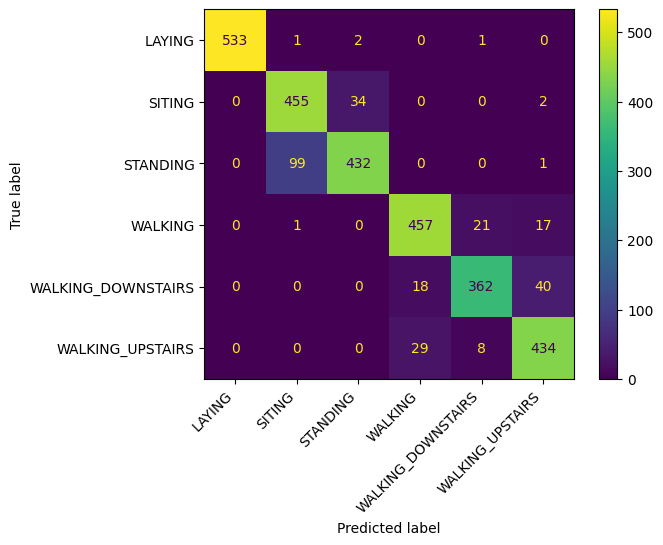

In [30]:
ConfusionMatrixDisplay.from_estimator(random_search_model_ht_reduced.best_estimator_, X_test_reduced, y_test_le, display_labels=le.classes_)
plt.xticks(rotation=45, ha='right');

# Summary

In [31]:
def highlight_max(data, hl_index=False, color='green'):
    if hl_index:
        is_max = data.groupby(level=1).transform('max') == data
    else:
        is_max = data.max() == data
    return [f'background-color: {color}' if v else '' for v in is_max]

In [32]:
names = [
    'Scikit-learn MLPClassifier Base',
    'Scikit-learn MLPClassifier Hypertuned',
    'Tensorflow DNN',
    'Scikit-learn MLPClassifier Reduced by Autoencoder'
]

predictions = [
    model_base.predict(X_test),
    random_search_model_ht.best_estimator_.predict(X_test),
    np.argmax(model_tf.predict(X_test), axis=1),
    random_search_model_ht_reduced.best_estimator_.predict(X_test_reduced)
]

dfs = []

for name, prediction in zip(names, predictions):
    df = (
            pd.DataFrame(
                classification_report(
                    y_test_le,
                    prediction, 
                    output_dict=True,
                    target_names=le.classes_
                )
            )
            .map(round, ndigits=4)
            .drop(index=['support'])
    )
    df.index = pd.MultiIndex.from_product([[name], df.index])

    dfs.append(df)

df_concat = pd.concat(dfs)
df_styled = df_concat.style.apply(
    highlight_max, 
    subset=pd.IndexSlice[:, le.classes_.tolist() + ['accuracy', 'macro avg', 'weighted avg']],
    hl_index=True,
)
df_styled

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step


The hypertuned model using scikit-learn's implementation of neural networks scored the highest accuracy. The model from tensorflow followed but only by a small margin since the tensorflow model was not hypertuned as greatly as that of the scikit-learn model. When using another scikit-learn model where the trained data has its dimensions reduced, it yielded a lower accuracy when compared to the base model. Most of the confusion of the models was between the SITTING and STANDING which makes sense since both activities do not require the person to move. From the 2D visualizations showed earlier, data points of the two activities are observed to be grouped together and is difficult to distinguish.

It can be argued that LAYING, SITTING, and STANDING can be grouped as non-locomotive activities while WALKING, WALKING_DOWNSTAIRS, and WALKING_UPSTAIRS can be grouped as locomotive activities. If these were reduced to a binary classification problem between locomotive and non-locomotive activities, it can be observed that the accuracy could be much higher as confusion between the 2 groups of activities is very small (hypertuned model only has low confusion).

Overall, the hypertuned neural network is still only ~96% and not significantly greater compared to the SVM model. An interpretation of this is that there could be measurements that are not fully accurate hence both SVM and neural networks could not perfectly differentiate the activities or if there are instances that an activity is very similar to another activity.


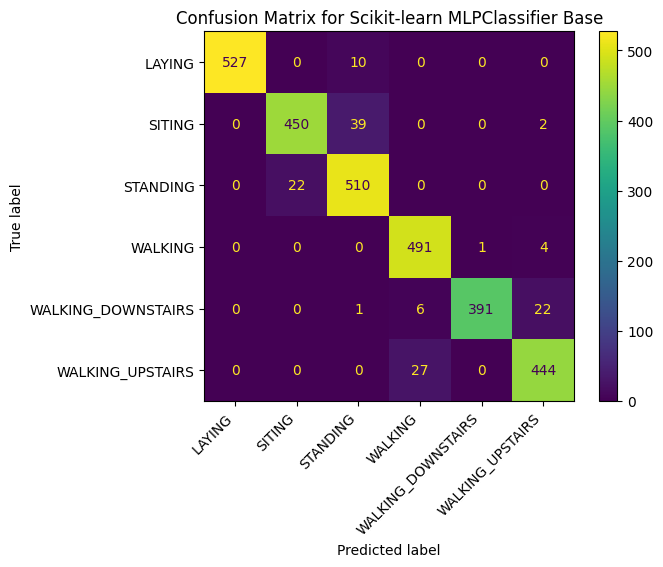

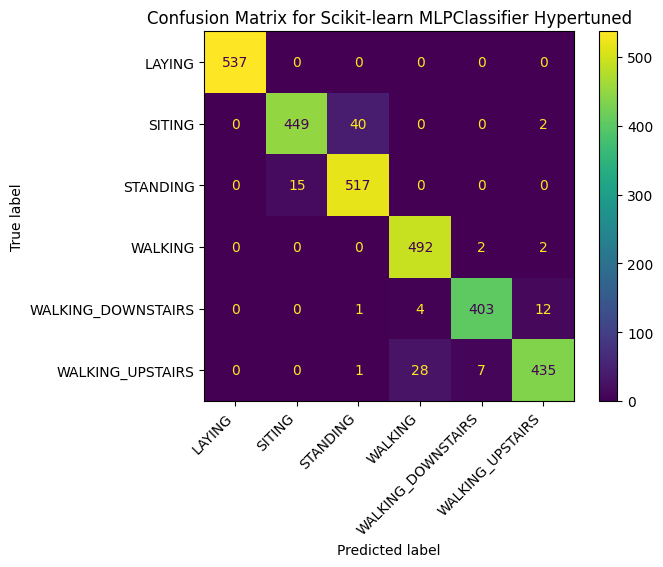

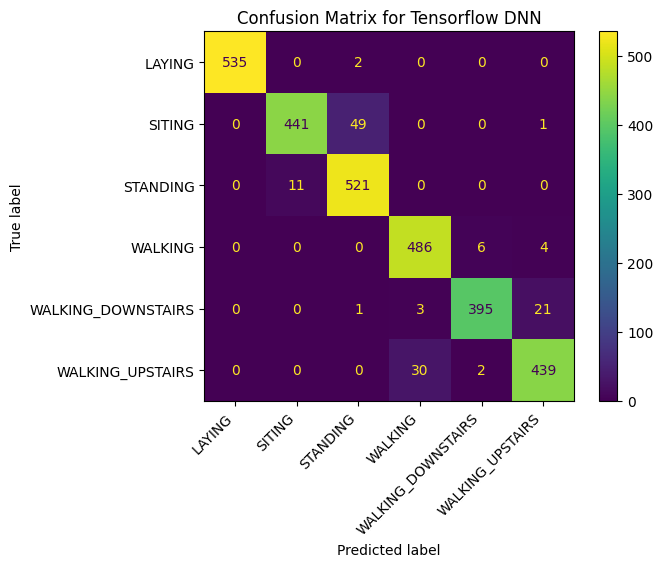

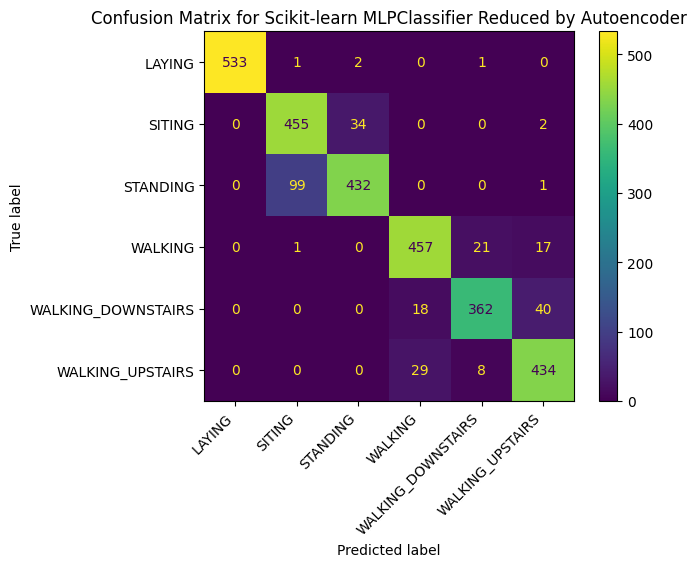

In [33]:
for name, prediction in zip(names, predictions):
    ConfusionMatrixDisplay.from_predictions(y_test_le, prediction, display_labels=le.classes_)
    plt.title(f'Confusion Matrix for {name}')
    plt.xticks(rotation=45, ha='right')